<a href="https://colab.research.google.com/github/MagdaGielazyn/final_project_image_recognition/blob/master/MRI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<span style="color: lightblue">

# ML - PROJEKT ZALICZENIOWY
### 1. Project overview

<span>

In [16]:
import sys
print(sys.executable)
print(sys.version)

/Users/Marcin_Sierakowski/Downloads/marcin/bin/python
3.9.6 (default, Dec  2 2025, 07:27:58) 
[Clang 17.0.0 (clang-1700.6.3.2)]


In [17]:
#import bibliotek:
import hashlib
import kagglehub
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import pathlib
import pandas as pd
import tensorflow as tf

from PIL import Image
#from sklearn.metrics import classification_report
#from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras import models, layers



In [18]:
run_locally=True
num_of_epochs = 10

In [19]:
#funkcje, ktore wrzucimy do folderku utils:

In [20]:
#sprawdzenie balansu rozlozenia klas w zbiorze:
def check_balance(df, target):
    df_percentage = df[target].value_counts(normalize=True) * 100
    num = df_percentage.max()
    if num == 25:
        descr = "Dane są idealnie zrównoważone."
    elif num <= 35:
        descr = "Dane są dobrze zrównoważone."
    elif num <= 45:
        descr = "Lekka nierównowaga – akceptowalna."
    elif num <= 55:
        descr = "Umiarkowana nierównowaga – warto monitorować."
    else:
        descr = "Silna nierównowaga – zalecane balansowanie danych."
    return descr

#wczytanie danych:
def data_reader(path: str, img_size=(150, 150), batch_size=None):
    dataset_path = kagglehub.dataset_download(path)
    train_dir = os.path.join(dataset_path, "Training")
    test_dir = os.path.join(dataset_path, "Testing")
    train_ds = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        image_size=img_size,
        batch_size=batch_size,
        label_mode="categorical",
        shuffle=False, ### na razie tak zamiast False zeby sciezki podpiac
    )
    test_ds = tf.keras.utils.image_dataset_from_directory(
        test_dir,
        image_size=img_size,
        batch_size=batch_size,
        label_mode="categorical",
        shuffle=False,
    )

    train_paths = tf.data.Dataset.from_tensor_slices(train_ds.file_paths)
    test_paths = tf.data.Dataset.from_tensor_slices(test_ds.file_paths)


    enriched_train_ds = tf.data.Dataset.zip((train_ds, train_paths))
    enriched_test_ds = tf.data.Dataset.zip((test_ds, test_paths))
    full_ds=enriched_train_ds.concatenate(enriched_test_ds)

    categories = set(train_ds.class_names+test_ds.class_names)
    #train_ds = train_ds.batch(batch_size)
    #test_ds = test_ds.batch(batch_size)

    return (full_ds, categories, train_ds, test_ds)

#zmiana datasetu na df:
def batched_dataset_to_df(ds):
    return pd.DataFrame([
        (p.numpy().decode(), int(np.argmax(y.numpy())))
        for (x, y), ps in ds
        for p, y in zip(ps, y)
    ], columns=["path", "label"])
def dataset_to_df(ds):
    return pd.DataFrame([
        (path.numpy().decode(), int(np.argmax(label.numpy())))
        for (image, label), path in ds
    ], columns=["path", "label"])

#znalezienie duplikatow:
def find_image_duplicates(**kwargs):
    datasets = list(kwargs.values())
    def image_hash(image):
      image_bytes = tf.io.serialize_tensor(image)
      return hashlib.md5(image_bytes.numpy()).hexdigest()
    if not datasets:
        return {
            "Liczba wszystkich obrazów:": 0,
            "Liczba duplikatów:": 0,
            "Unikalne obrazy:": 0,
            "Duplikaty szczegóły:": []
        }

    full_ds = datasets[0]
    for ds in datasets[1:]:
        full_ds = full_ds.concatenate(ds)

    hash_to_path = {}
    duplicates = []
    total_images = 0

    for (img, _), path in full_ds:
      total_images += 1
      h = image_hash(img)
      #print(h)
      path_str = path.numpy().decode()

      if h in hash_to_path:

          duplicates.append((path_str, hash_to_path[h]))
      else:

          hash_to_path[h] = path_str

    return {
        "Number of images": total_images,
        "Number of duplicates": len(duplicates),
        "Unique images": len(hash_to_path),
        "Duplicates details": duplicates
    }

#pokazanie rozdystrybuuowania klas w zbiorze:
def plot_class_distribution(df, column="label_name", title="Rozkład klas"):
    labels = df[column].value_counts().index.tolist()
    colors = sns.color_palette("Blues", n_colors=len(labels))

    df[column].value_counts(normalize=True).plot(
        kind="pie",
        autopct="%1.1f%%",
        labels=labels,
        colors=colors,
        title=title,
        ylabel=""
    )

    plt.show()

#usuniecie zduplikowanych obrazow:
def remove_paths_from_dataset(dataset, paths_to_remove):
    paths_to_remove = tf.constant(paths_to_remove)
    def keep_fn(data, path):
        is_equal = tf.reduce_any(tf.equal(paths_to_remove, path))
        return tf.logical_not(is_equal)

    return dataset.filter(keep_fn)


#pokazanie obrazow ze zbiorow:
def show_images(paths, rows=None, cols=None, figsize=(16, 8), update_path=False):
    n = len(paths)
    if rows is None and cols is None:
        cols = min(5, n)
        rows = math.ceil(n / cols)
    elif rows is None:
        rows = math.ceil(n / cols)
    elif cols is None:
        cols = math.ceil(n / rows)

    plt.figure(figsize=figsize)
    if update_path:
        paths = [path.replace('/kaggle/input/brain-tumor-mri-dataset',update_path) for path in paths]
    for i, path in enumerate(paths, 1):
        img = Image.open(path)
        plt.subplot(rows, cols, i)
        plt.imshow(img)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

#podzial datasetu na traningowy i testowy:
def split_train_test_ds(dataset, dataset_size,split_ratios={"val":0.2,"test":0.2,"train":0.6}, limit_ds=None):
    dataset = dataset.shuffle(buffer_size=dataset_size)
    train_dataset = dataset.take(int(split_ratios['train']*dataset_size))
    val_dataset = dataset.skip(int(split_ratios['train']*dataset_size)).take(int(split_ratios['val']*dataset_size))
    test_dataset = dataset.skip(int((split_ratios['train']+split_ratios['val'])*dataset_size))

    if limit_ds is not None:
        train_ratio = sum(1 for _ in train_dataset)*limit_ds
        test_ratio = sum(1 for _ in test_dataset)*limit_ds
        val_ratio = sum(1 for _ in val_dataset)*limit_ds
        train_dataset = train_dataset.take(train_ratio)
        test_dataset = test_dataset.take(test_ratio)
        val_dataset = val_dataset.take(val_ratio)
    return train_dataset, test_dataset, val_dataset


**Problem badawczy:** Zbudowanie i ocena modelu klasyfikacji obrazów MRI mózgu z wykorzystaniem sieci konwolucyjnej (CNN – Convolutional Neural Network). Model ma rozpoznawać rodzaj obrazu MRI spośród czterech kategorii:

*   Glioma tumor - Glejak
*   Meningioma tumor - Oponiak
*   Pituitary tumor - Guz przysadki mózgowej
*   No tumor - Brak guza (pacjent zdrowy)

Zadanie to jest przykładem klasyfikacji binominalnej obrazów medycznych.


Analiza obrazów MRI jest kluczowa w diagnostyce chorób mózgu, ale wymaga czasu i specjalistycznej wiedzy. Automatyczne modele oparte na uczeniu głębokim, takie jak CNN, mogą wspierać lekarzy w szybszym i bardziej obiektywnym wstępnym rozpoznaniu typu guza lub jego braku. Projekt ma na celu sprawdzenie, jak dobrze prosty model CNN radzi sobie z takim zadaniem.

Opis danych
W projekcie wykorzystano publiczny zbiór danych z platformy Kaggle: Brain Tumor MRI Dataset. Zbiór zawiera obrazy MRI mózgu podzielone na foldery odpowiadające czterem klasom. Dane są już rozdzielone na zbiór treningowy (Training) oraz testowy (Testing).

In [21]:
#pobranie danych i wczytanie danych - dane laczymy by pozniej sprawdzic czy nie ma duplikatow
full_ds, categories, tr, ts = data_reader("masoudnickparvar/brain-tumor-mri-dataset")


Found 5600 files belonging to 4 classes.
Found 1600 files belonging to 4 classes.


In [22]:
#sprawdzenie katergorii (etykiet)
categories

{'glioma', 'meningioma', 'notumor', 'pituitary'}

In [23]:
#opis datasetu
full_ds

<_ConcatenateDataset element_spec=((TensorSpec(shape=(150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4,), dtype=tf.float32, name=None)), TensorSpec(shape=(), dtype=tf.string, name=None))>

In [24]:
#sprawdzenie reczne  etykiet w one hot encoding dla 5 pierwszych losowych etykiet
for (_, labels),_  in full_ds.shuffle(7200).take(5):
    print(labels)


tf.Tensor([0. 1. 0. 0.], shape=(4,), dtype=float32)
tf.Tensor([0. 0. 0. 1.], shape=(4,), dtype=float32)
tf.Tensor([0. 0. 0. 1.], shape=(4,), dtype=float32)
tf.Tensor([0. 0. 0. 1.], shape=(4,), dtype=float32)
tf.Tensor([1. 0. 0. 0.], shape=(4,), dtype=float32)


2026-02-26 21:20:48.101403: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [25]:
#sprawdzenie reczne tensorow obrazow dla 1 pierwszego obrazka
for (images, _),_  in full_ds.take(1):
    print(images)


tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(150, 150, 3), dtype=float32)


<span style="color: lightblue">

### 2.  EDA - Explanatory data analysis

<span>

In [26]:
#sprawdzenie czy mamy zduplikowane obrazy w datasecie - zbiory tetsowy i treningowy wczesniej zostaly polaczone w calosc by uniknac duplikatow
#pomiedzy zbiorem treningowym a testowym, ktore moglyby spowdowac przeuczenie sie

duplicates = find_image_duplicates(full_ds=full_ds)

In [27]:
duplicates

{'Number of images': 7200,
 'Number of duplicates': 322,
 'Unique images': 6878,
 'Duplicates details': [('/Users/Marcin_Sierakowski/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/2/Training/meningioma/Tr-me_1242.jpg',
   '/Users/Marcin_Sierakowski/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/2/Training/meningioma/Tr-aug-me_90.jpg'),
  ('/Users/Marcin_Sierakowski/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/2/Training/meningioma/Tr-me_1274.jpg',
   '/Users/Marcin_Sierakowski/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/2/Training/meningioma/Tr-aug-me_98.jpg'),
  ('/Users/Marcin_Sierakowski/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/2/Training/meningioma/Tr-me_1295.jpg',
   '/Users/Marcin_Sierakowski/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/2/Training/meningioma/Tr-aug-me_95.jpg'),
  ('/Users/Marcin_

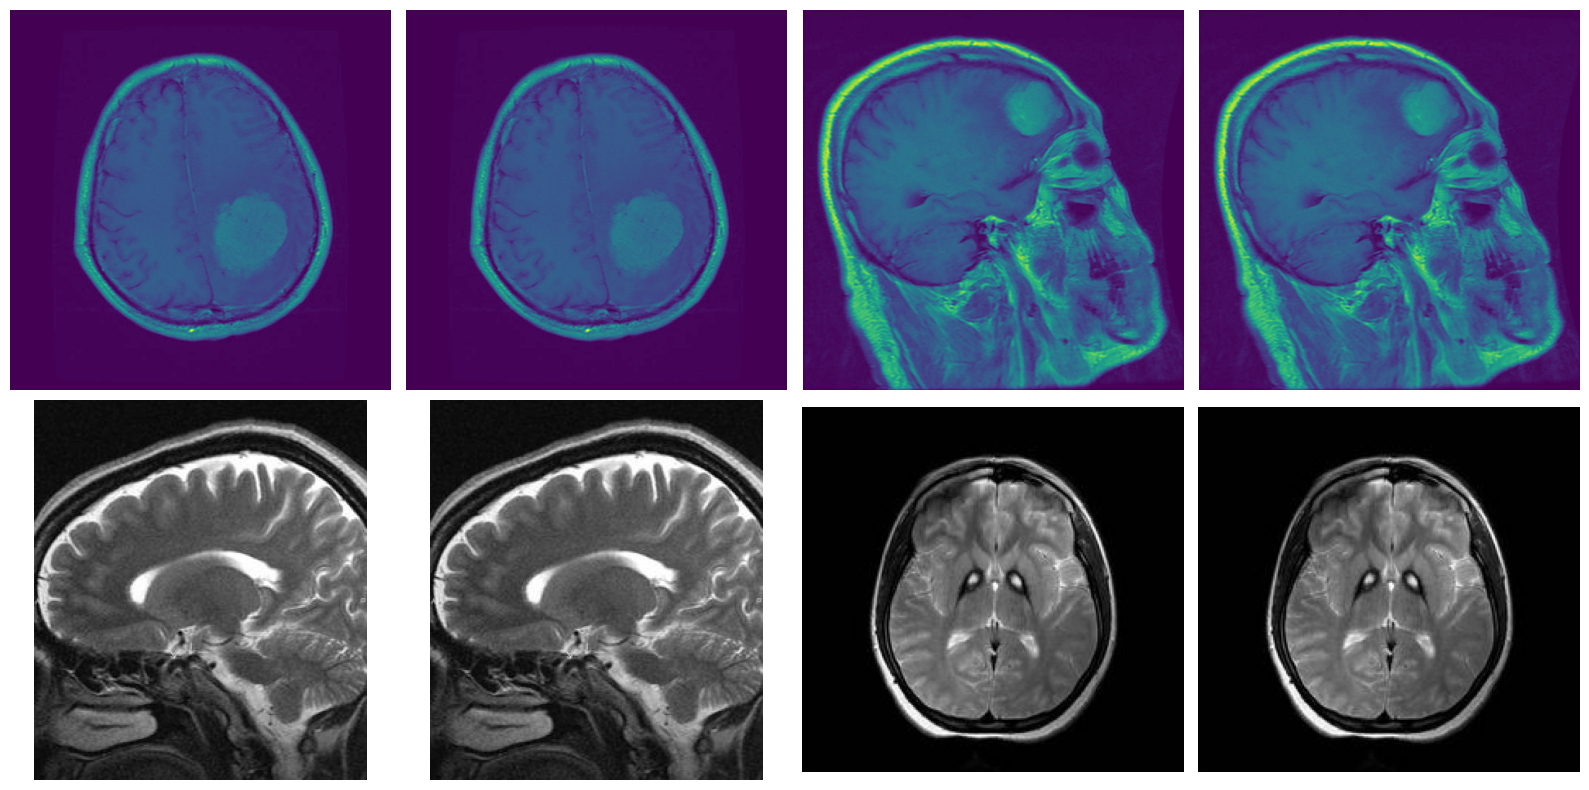

In [28]:
#wizualizacja przykladowych duplikatow:
if run_locally:
  show_images(['/kaggle/input/brain-tumor-mri-dataset/Training/meningioma/Tr-me_1242.jpg', '/kaggle/input/brain-tumor-mri-dataset/Training/meningioma/Tr-aug-me_90.jpg', '/kaggle/input/brain-tumor-mri-dataset/Training/meningioma/Tr-me_1274.jpg',
    '/kaggle/input/brain-tumor-mri-dataset/Training/meningioma/Tr-aug-me_98.jpg', '/kaggle/input/brain-tumor-mri-dataset/Testing/notumor/Te-no_92.jpg',
    '/kaggle/input/brain-tumor-mri-dataset/Training/notumor/Tr-no_1319.jpg', '/kaggle/input/brain-tumor-mri-dataset/Testing/notumor/Te-no_194.jpg',
    '/kaggle/input/brain-tumor-mri-dataset/Training/notumor/Tr-no_1004.jpg'], rows = 2, cols = 4, update_path='/Users/Marcin_Sierakowski/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/2')
else:
  show_images(['/kaggle/input/brain-tumor-mri-dataset/Training/meningioma/Tr-me_1242.jpg', '/kaggle/input/brain-tumor-mri-dataset/Training/meningioma/Tr-aug-me_90.jpg', '/kaggle/input/brain-tumor-mri-dataset/Training/meningioma/Tr-me_1274.jpg',
    '/kaggle/input/brain-tumor-mri-dataset/Training/meningioma/Tr-aug-me_98.jpg', '/kaggle/input/brain-tumor-mri-dataset/Testing/notumor/Te-no_92.jpg',
    '/kaggle/input/brain-tumor-mri-dataset/Training/notumor/Tr-no_1319.jpg', '/kaggle/input/brain-tumor-mri-dataset/Testing/notumor/Te-no_194.jpg',
    '/kaggle/input/brain-tumor-mri-dataset/Training/notumor/Tr-no_1004.jpg'], rows = 2, cols = 4,)


In [29]:
#Identyfikacja duplikatow do usuniecia
paths_to_remove = [e[0] for e in duplicates['Duplicates details']]

In [30]:
#usuniecie duplikatow
deduplicated_ds = remove_paths_from_dataset(full_ds, paths_to_remove)

In [31]:
#Ponowne sprawdzenie czy nie ma duplikatow w celu upewnienia sie, ze zostaly usuniete porpawnie:
final_stat = find_image_duplicates(deduplicated_ds=deduplicated_ds)
final_stat

{'Number of images': 6878,
 'Number of duplicates': 0,
 'Unique images': 6878,
 'Duplicates details': []}

In [32]:
#podzial zbiory na zbior testowy i traningowy
train_ds, test_ds, val_ds = split_train_test_ds(deduplicated_ds, final_stat['Number of images'],)

In [33]:
#opis traningowego datasetu:
train_ds

<_TakeDataset element_spec=((TensorSpec(shape=(150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4,), dtype=tf.float32, name=None)), TensorSpec(shape=(), dtype=tf.string, name=None))>

In [34]:
#opis testowego datasetu:
test_ds

<_SkipDataset element_spec=((TensorSpec(shape=(150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4,), dtype=tf.float32, name=None)), TensorSpec(shape=(), dtype=tf.string, name=None))>

In [35]:
#zmiana datasetu treningowego na df:
train_df = dataset_to_df(train_ds)
train_df.head(100)

2026-02-26 21:20:56.434368: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


,path,label
0,/Users/Marcin_Sierakowski/.cache/kagglehub/dat...,3
1,/Users/Marcin_Sierakowski/.cache/kagglehub/dat...,0
2,/Users/Marcin_Sierakowski/.cache/kagglehub/dat...,3
3,/Users/Marcin_Sierakowski/.cache/kagglehub/dat...,0
4,/Users/Marcin_Sierakowski/.cache/kagglehub/dat...,1
...,...,...
95,/Users/Marcin_Sierakowski/.cache/kagglehub/dat...,3
96,/Users/Marcin_Sierakowski/.cache/kagglehub/dat...,0
97,/Users/Marcin_Sierakowski/.cache/kagglehub/dat...,3
98,/Users/Marcin_Sierakowski/.cache/kagglehub/dat...,3


In [36]:
#zmiana datasetu treningowego na df:
test_df = dataset_to_df(test_ds)
test_df.head(100)

,path,label
0,/Users/Marcin_Sierakowski/.cache/kagglehub/dat...,0
1,/Users/Marcin_Sierakowski/.cache/kagglehub/dat...,3
2,/Users/Marcin_Sierakowski/.cache/kagglehub/dat...,1
3,/Users/Marcin_Sierakowski/.cache/kagglehub/dat...,0
4,/Users/Marcin_Sierakowski/.cache/kagglehub/dat...,2
...,...,...
95,/Users/Marcin_Sierakowski/.cache/kagglehub/dat...,3
96,/Users/Marcin_Sierakowski/.cache/kagglehub/dat...,1
97,/Users/Marcin_Sierakowski/.cache/kagglehub/dat...,3
98,/Users/Marcin_Sierakowski/.cache/kagglehub/dat...,3


In [37]:
#wyciagniecie nazwy etykiety dla konkretnej labelki zbioru treningowego
train_df["label_name"] = train_df["path"].apply(lambda p: p.split("/")[-2])

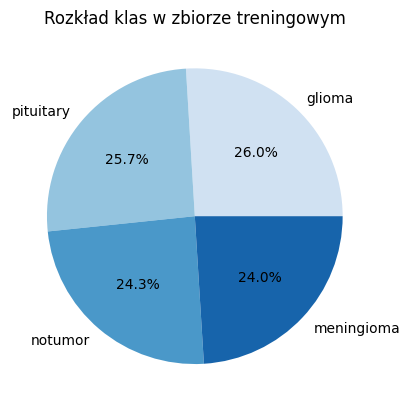

In [38]:
#pokazanie rozkladu klas w zbiorze treningowym
plot_class_distribution(train_df, "label_name", "Rozkład klas w zbiorze treningowym")

In [39]:
#sprawdzenie czy balans rozkladu klas w zbiorze treningowym jest prawidlowo zrownowazony
check_balance(train_df, 'label_name')

'Dane są dobrze zrównoważone.'

In [40]:
#wyciagniecie nazwy etykiety dla konkretnej labelki zbioru testowego
test_df["label_name"] = train_df["path"].apply(lambda p: p.split("/")[-2])

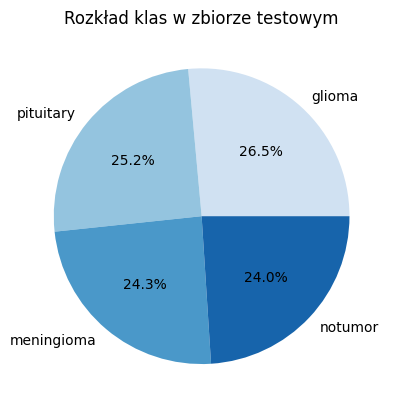

In [41]:
#pokazanie rozkladu klas w zbiorze testowym
plot_class_distribution(test_df, "label_name", "Rozkład klas w zbiorze testowym")

In [42]:
#sprawdzenie czy balans rozkladu klas w zbiorze testowym jest prawidlowo zrownowazony
check_balance(test_df, 'label_name')

'Dane są dobrze zrównoważone.'

**Wniosek ogolny:** Rozkład klas w zbiorze treningowym i testowym jest identyczny, co wskazuje na prawidłowy podział danych. Zbiory są  zbalansowane, co sprzyja stabilnemu trenowaniu modelu klasyfikacyjnego

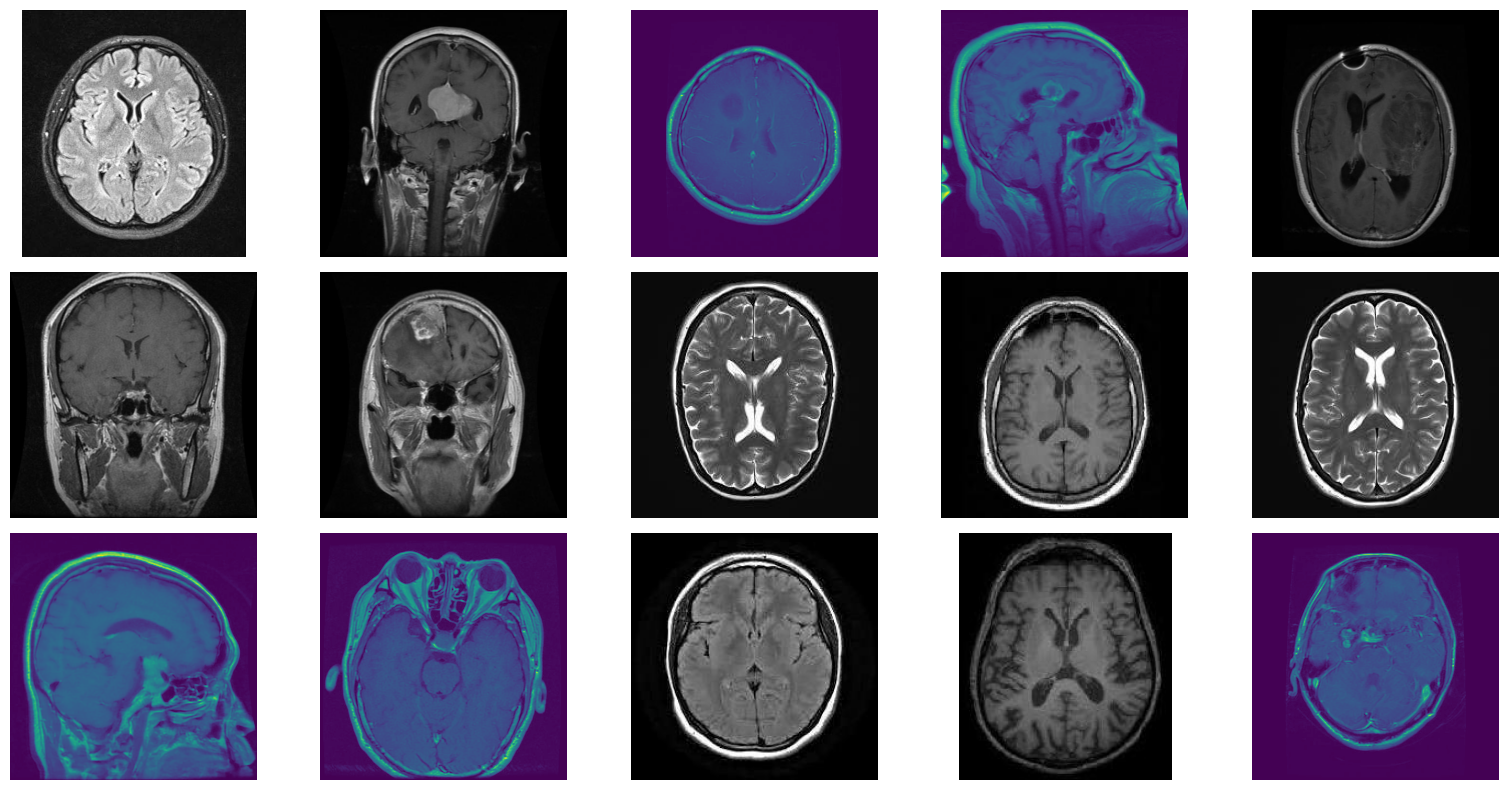

In [43]:
#Wizualizacja przykladowych obrazow:
sample = train_df.sample(n=15, random_state=42)
show_images(paths=sample["path"].tolist(), rows=3, cols=5)





**Wnioski:**


*   Kolorystyka obrazw rozni sie - czesc obrazow jest czarnobiala, a czesc w kolorach -> Potrzebna normalizacja
*   Jasnosc i kontrast sa zroznicowane nawet w ramach odcieni czerni - raz obraz jest jasniejszy, raz ciemniejszy -> Potrzebna normalizacja
*   Obrazy mają różne rozmiary -->  Potrzebny crop
*   Obrazy pochodzą z różnych płaszczyzn przekroju, rozne orientacje i skale --> Potrzebne filtry
*   Na obrazach widac napisy np pasek u gory zdjecia
*   Na obrazkach jest duzo tla







In [44]:
#konwersja RGB do greyscale po to by zmienic obrazy do odcieni szarosci
train_ds2 = train_ds.map(
    lambda data, path: (tf.image.rgb_to_grayscale(data[0]), data[1])
)

test_ds2 = test_ds.map(
    lambda data, path: (tf.image.rgb_to_grayscale(data[0]), data[1])
)

In [45]:
#przyciecie obrazu by zostawic 80% w celu pozbycia sie nadmiaru czarnego tla
train_ds2 = train_ds2.map(
    lambda x, y: (tf.image.central_crop(x, 0.8), y)
)

test_ds2 = test_ds2.map(
    lambda x, y: (tf.image.central_crop(x, 0.8), y)
)

In [46]:
#zmiana obrazu na 150 na 150 by wszystkie obrazy mialy identyczne wymiary
train_ds2 = train_ds2.map(
    lambda x, y: (tf.image.resize(x, (150,150)), y)
)

test_ds2 = test_ds2.map(
    lambda x, y: (tf.image.resize(x, (150,150)), y)
)

In [47]:
#normalizacja by model mogl sie szybciej uczyc
train_ds2 = train_ds2.map(
    lambda x, y: (tf.cast(x, tf.float32) / 255.0, y)
)

test_ds2 = test_ds2.map(
    lambda x, y: (tf.cast(x, tf.float32) / 255.0, y)
)

In [48]:
#powrot do RGB by zachowac kompatybilnosc modelu z RGB
train_ds2 = train_ds2.map(lambda x, y: (tf.image.grayscale_to_rgb(x), y))
test_ds2  = test_ds2.map(lambda x, y: (tf.image.grayscale_to_rgb(x), y))

In [49]:
#augumentacja zbioru treningowego by zmniejszyc overfitting i zwiekszyc stabilnosc modelu
augment = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.1),
])

train_ds2 = train_ds2.map(lambda x,y: (augment(x), y))

In [50]:
#sprawdzenie struktury pojedynczgeo elementu datasetu
print(train_ds2.element_spec)

(TensorSpec(shape=(150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4,), dtype=tf.float32, name=None))


<span style="color: lightblue">

### 3. Model

<span>

In [51]:
#definicja model unet like

def unet_like_model():
    inputs = tf.keras.Input(shape=(150, 150, 3), dtype="float32")

    # Encoder
    x = tf.keras.layers.Conv2D(32, (3,3), activation="relu", padding="same")(inputs)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)

    x = tf.keras.layers.Conv2D(64, (3,3), activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)

    # Bottleneck
    x = tf.keras.layers.Conv2D(128, (3,3), activation="relu", padding="same")(x)

    # Decoder (bardzo uproszczony)
    x = tf.keras.layers.UpSampling2D((2,2))(x)
    x = tf.keras.layers.Conv2D(64, (3,3), activation="relu", padding="same")(x)

      # Decoder (bardzo uproszczony)
    x = tf.keras.layers.UpSampling2D((2,2))(x)
    x = tf.keras.layers.Conv2D(32, (3,3), activation="relu", padding="same")(x)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    outputs = tf.keras.layers.Dense(4, activation="softmax")(x)

    return tf.keras.Model(inputs, outputs)

model = unet_like_model()
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 74, 74, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 74, 74, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 148, 148, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 148, 148, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 185,636 (725.14 KB)

 Trainable params: 185,636 (725.14 KB)

 Non-trainable params: 0 (0.00 B)

In [52]:
#konfiguracja uczenia:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
    #learning_rate=0.01
)

In [53]:
#batchowanie by model uczyl sie szybciej i stabilniej:
batched_train_ds2 = train_ds2.batch(32)
batched_test_ds2 = test_ds2.batch(32)

In [54]:
#sprawdzenie struktury zbioru treningowego
batched_train_ds2

<_BatchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [ ]:
#trening
history = model.fit(
    batched_train_ds2,
    validation_data=batched_test_ds2,
    epochs=num_of_epochs
)

Epoch 1/10
    129/Unknown 48s 355ms/step - accuracy: 0.3262 - loss: 1.2926

/Users/Marcin_Sierakowski/Downloads/marcin/lib/python3.9/site-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


129/129 ━━━━━━━━━━━━━━━━━━━━ 53s 396ms/step - accuracy: 0.3270 - loss: 1.2918 - val_accuracy: 0.6228 - val_loss: 0.9663
Epoch 2/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 52s 398ms/step - accuracy: 0.6135 - loss: 0.9900 - val_accuracy: 0.4658 - val_loss: 1.3234
Epoch 3/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 51s 387ms/step - accuracy: 0.6654 - loss: 0.8368 - val_accuracy: 0.6860 - val_loss: 0.8362
Epoch 4/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.6827 - loss: 0.8061

2026-02-26 21:24:21.059703: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


129/129 ━━━━━━━━━━━━━━━━━━━━ 51s 387ms/step - accuracy: 0.6826 - loss: 0.8061 - val_accuracy: 0.6701 - val_loss: 0.8811
Epoch 5/10
104/129 ━━━━━━━━━━━━━━━━━━━━ 8s 352ms/step - accuracy: 0.6912 - loss: 0.7701

In [ ]:
#wykres, który pokazuje jak accuracy modelu zmienia się podczas treningu i czy model uczy się poprawnie
plt.figure(figsize=(8,5))
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="val")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Wniosek: Model uczy sie prawidlowo

In [ ]:
#sprawdzenie dokladnosci i straty na zbiorze testowym
loss, accuracy = model.evaluate(batched_test_ds2, verbose=0)

print(f"Dokładność na zbiorze testowym: {accuracy:.4f}")
print(f"Strata na zbiorze testowym: {loss:.4f}")

In [ ]:
#confusion matrix
class_names = ["glioma", "meningioma", "notumor", "pituitary"]

y_true = np.argmax(np.concatenate([y for x, y in batched_test_ds2], axis=0), axis=1)
y_pred = np.argmax(model.predict(batched_test_ds2), axis=1)

cm = confusion_matrix(y_true, y_pred)

ConfusionMatrixDisplay(cm, display_labels=class_names).plot(cmap="Reds")
plt.show()

Wnioski:

In [ ]:
#metryki: recall i precision,  accuracy, f1 score etc
#heatmapa do metryk
#moglibysmy tez zrobic wizualizacje - obrazek i pod spodem info czy trag=filismy czy nie, robilismy cos takiego z Kuba

In [ ]:
#metryki (precision - jak zcesto model mial racje, recall - ile prawdizwych przypadkow wykryl model, )

print(classification_report(y_true, y_pred, target_names=class_names))

In [ ]:
#prosta wizualizacja
class_names = ["glioma", "meningioma", "notumor", "pituitary"]

x, y = next(iter(batched_test_ds2))
pred = np.argmax(model.predict(x, verbose=0), axis=1)


if len(y.shape) > 1:
    y = np.argmax(y.numpy(), axis=1)
else:
    y = y.numpy()

plt.figure(figsize=(10,6))

for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(x[i])
    plt.title(
        f"T:{class_names[y[i]]}\nP:{class_names[pred[i]]}",
        color="green" if y[i]==pred[i] else "red"
    )
    plt.axis("off")

plt.tight_layout()
plt.show()

<span style="color: lightblue">

### 4. Optymalizacja

<span>

In [ ]:
#tu optuna :) uzyjmy slajdow Natalii by zidentyfiukowac ktore parametry chcemy podrasowac (ostatnia przeka z architektury z zajec)

# Wypisać prametry do optymalizacji

<span style="color: lightblue">

### 5. Wnioski

<span>

In [ ]:
#wylistowac wnioski
#sprawdzic w chat i w internecie czy jest do obrazkow cos na podobienstwo shapa i jesli tak to uzyc